In [23]:
import numpy as np
import tensorflow as tf
from PIL import Image
import chess
from config import class_labels
from utils import visualize_board, board_to_fen, preprocess_image

In [24]:
# Path to the TFLite model
model_name = "chess_classifier_10k_quant"
tflite_model_path = f"models/{model_name}.tflite"
is_quantized_model = "_quant" in model_name

interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [25]:
def classify_squares_batch(squares):
    processed_squares = [preprocess_image(img, is_quantized_model) for img in squares]
    batch = np.vstack(
        processed_squares
    )  # This should create a shape of [batch_size, height, width, channels]

    assert len(batch.shape) == 4, f"Expected 4D input tensor, got {batch.shape}"

    interpreter.resize_tensor_input(input_details[0]["index"], batch.shape)
    interpreter.allocate_tensors()

    interpreter.set_tensor(input_details[0]["index"], batch)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]["index"])

    class_indices = np.argmax(predictions, axis=1)
    return [class_labels[idx] for idx in class_indices]


def classify_chessboard(chessboard_image_path):
    chessboard = Image.open(chessboard_image_path)
    board_size = chessboard.size[0] // 8
    board_configuration = [[""] * 8 for _ in range(8)]

    squares = []
    positions = []

    for row in range(8):
        for col in range(8):
            left = col * board_size
            upper = row * board_size
            right = left + board_size
            lower = upper + board_size
            square = chessboard.crop((left, upper, right, lower))
            squares.append(square)
            positions.append((row, col))

    classifications = classify_squares_batch(squares)

    for (row, col), classification in zip(positions, classifications):
        board_configuration[row][col] = classification

    return board_configuration

In [26]:
chessboard_image_path = "test/test3.png"
board_configuration = classify_chessboard(chessboard_image_path)

for row in board_configuration:
    print(row)

['w_rook', 'empty', 'w_bishop', 'w_king', 'w_queen', 'w_bishop', 'empty', 'w_rook']
['w_pawn', 'w_pawn', 'w_pawn', 'w_knight', 'empty', 'w_pawn', 'empty', 'w_pawn']
['empty', 'empty', 'empty', 'empty', 'empty', 'w_knight', 'empty', 'empty']
['empty', 'empty', 'empty', 'w_pawn', 'w_pawn', 'empty', 'w_pawn', 'empty']
['empty', 'empty', 'empty', 'b_pawn', 'b_pawn', 'empty', 'empty', 'empty']
['empty', 'empty', 'empty', 'empty', 'empty', 'b_pawn', 'empty', 'empty']
['b_pawn', 'b_pawn', 'b_pawn', 'empty', 'b_knight', 'empty', 'b_pawn', 'b_pawn']
['b_rook', 'b_knight', 'b_bishop', 'b_king', 'b_queen', 'b_bishop', 'empty', 'b_rook']


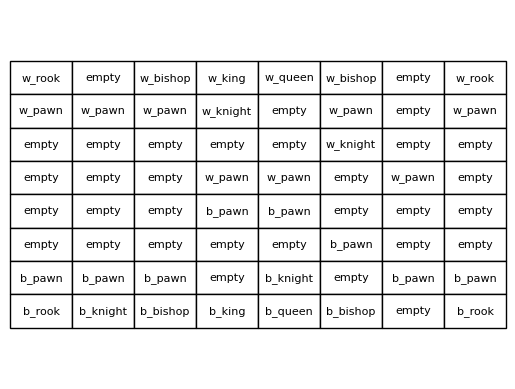

In [27]:
visualize_board(board_configuration)

R1BKQB1R/PPPN1P1P/5N2/3PP1P1/3pp3/5p2/ppp1n1pp/rnbkqb1r


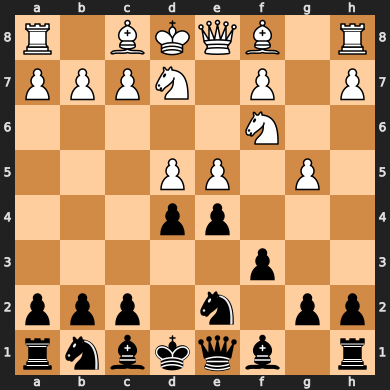

In [28]:
fen = board_to_fen(board_configuration)
print(fen)
chess.Board(fen=fen)